# Introduction: Real estate data cleansing

This jupyter notebook shows steps and procedures on how to handle raw scraped data. First, we will try to detect all of the real estate entries that will be useless for our analysis - the entries which will have for certain key columns missing values. For those columns, we wouldn't be able to populate those missing values with any strategy. We will also try to find outliers that may mislead us in analysing and later in modeling. 

We're also going to try to additionally clean and prepare dataset for analysis, by using some preexisting knowledge and intuition about the real estate market in Serbia.

All of the changes on the original, raw, scraped dataset will be saved in PostgreSQL database. 

# 1. Connecting to the database

In [1]:
# Importting libraries
import json
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Loading db connection parameters from json file
db_params = None
with open('../database/db_connetion.json') as db_file:
    # Loading db connection parameters 
    db_params = json.load(db_file)

In [3]:
# Connecting to the database
conn = psycopg2.connect(
    host=db_params['host'], 
    port=db_params['port'], 
    database=db_params['database'], 
    user=db_params['user'], 
    password=db_params['password']
    )

In [4]:
# Getting the real estate data from database
real_estate = pd.read_sql_query('Select * from properties', conn)

In [5]:
real_estate.head()

,id,listing_type,property_type,price,location_city,location_city_district,area_property,area_land,construction_type,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms,source
0,92,s,a,89400.0,Novi Sad,Liman 2,62.0,NaN,None,NaN,3.0,True,Centralno,2.5,1.0,https://www.4zida.rs/prodaja/stanovi/novi-sad/...
1,93,s,a,109000.0,Beograd,Stari Grad,71.0,NaN,1974,9.0,7.0,False,Centralno,2.0,1.0,https://www.4zida.rs/prodaja/stanovi/beograd/o...
2,94,s,a,149500.0,Stari Grad,Dorćol,74.0,NaN,1939,4.0,2.0,True,Centralno,3.0,1.0,https://www.4zida.rs/prodaja/stanovi/beograd/o...
3,95,s,a,108000.0,Beograd,Zvezdara,60.0,NaN,2020,4.0,3.0,False,Etažno,2.5,1.0,https://www.4zida.rs/prodaja/stanovi/beograd/o...
4,96,s,a,145000.0,Beograd,Vračar,96.0,NaN,2005,2.0,1.0,True,Etažno,4.5,1.0,https://www.4zida.rs/prodaja/stanovi/beograd/o...


In [6]:
real_estate.describe()

,id,price,area_property,area_land,num_floors_building,apartment_floor,num_rooms,num_bathrooms
count,21975.000000,2.196100e+04,21961.000000,4556.000000,8533.000000,13422.000000,14750.000000,21968.000000
mean,11311.184710,8.112130e+04,151.307727,373.279888,5.607641,3.247057,2.426169,1.177349
std,6439.875954,2.022170e+05,1801.402983,8379.566755,3.755327,5.804599,1.000766,0.653074
min,92.000000,1.000000e+00,1.000000,0.010000,1.000000,-1.000000,1.000000,1.000000
25%,5677.500000,6.000000e+02,50.000000,4.000000,4.000000,1.000000,2.000000,1.000000
50%,11346.000000,4.430000e+04,73.000000,7.000000,5.000000,2.000000,2.000000,1.000000
75%,16905.500000,9.500000e+04,127.000000,17.000000,6.000000,4.000000,3.000000,1.000000
max,22399.000000,1.500000e+07,153300.000000,443036.000000,30.000000,100.000000,8.000000,33.000000


# 2. Handling missing values

## 2.1. Real estate properties without source information
Droping rows (properties) from dataframe which don't have valid web page as their source of information.

In [7]:
# Entries that don't have source link
indexes_to_remove = real_estate[real_estate['source'].isnull()].index
real_estate[real_estate['source'].isnull()]

,id,listing_type,property_type,price,location_city,location_city_district,area_property,area_land,construction_type,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms,source
15245,15670,r,a,NaN,None,None,NaN,NaN,None,NaN,NaN,None,None,NaN,NaN,None
18449,18874,r,a,NaN,None,None,NaN,NaN,None,NaN,NaN,None,None,NaN,NaN,None
18451,18876,r,a,NaN,None,None,NaN,NaN,None,NaN,NaN,None,None,NaN,NaN,None
18532,18957,r,a,NaN,None,None,NaN,NaN,None,NaN,NaN,None,None,NaN,NaN,None
19379,19803,r,a,NaN,None,None,NaN,NaN,None,NaN,NaN,None,None,NaN,NaN,None
20646,21071,r,a,NaN,None,None,NaN,NaN,None,NaN,NaN,None,None,NaN,NaN,None
20705,21130,r,a,NaN,None,None,NaN,NaN,None,NaN,NaN,None,None,NaN,NaN,None


In [8]:
# Removing properties that don't have source link
real_estate = real_estate.drop(indexes_to_remove)

## 2.2. Real estate properties without both the city and the city district information
Removing real estete entries that don't have neither city nor city districs information.

In [9]:
# Properties that don't have neither the city nor city district 
indexes_to_remove = real_estate[real_estate['location_city_district'].isnull() & real_estate['location_city'].isnull()].index 
real_estate[real_estate['location_city_district'].isnull() & real_estate['location_city'].isnull()]

,id,listing_type,property_type,price,location_city,location_city_district,area_property,area_land,construction_type,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms,source
10149,10508,s,h,NaN,None,None,NaN,NaN,None,NaN,NaN,False,None,NaN,1.0,https://www.4zida.rs/prodaja/kuce/kragujevac/o...
11783,12138,s,h,NaN,None,None,NaN,NaN,None,NaN,NaN,False,None,NaN,1.0,https://www.4zida.rs/prodaja/kuce/novi-sad/ogl...
13772,14130,s,h,NaN,None,None,NaN,NaN,None,NaN,NaN,False,None,NaN,1.0,https://www.4zida.rs/prodaja/kuce/novi-sad/ogl...
13778,14136,s,h,NaN,None,None,NaN,NaN,None,NaN,NaN,False,None,NaN,1.0,https://www.4zida.rs/prodaja/kuce/novi-sad/ogl...
13779,14137,s,h,NaN,None,None,NaN,NaN,None,NaN,NaN,False,None,NaN,1.0,https://www.4zida.rs/prodaja/kuce/beocin-opsti...
13780,14138,s,h,NaN,None,None,NaN,NaN,None,NaN,NaN,False,None,NaN,1.0,https://www.4zida.rs/prodaja/kuce/novi-sad/ogl...
13781,14139,s,h,NaN,None,None,NaN,NaN,None,NaN,NaN,False,None,NaN,1.0,https://www.4zida.rs/prodaja/kuce/sremski-karl...


In [10]:
# Removing properties that don't have neither a city nor city district information
real_estate = real_estate.drop(indexes_to_remove)

## 2.3.  Real estate properties without the city district information
Trying to resolve city district base on a city name. 

In [11]:
# Getting the real estate properties that don't have information on city district
no_city_district = real_estate[real_estate['location_city_district'].isnull()]
real_estate[real_estate['location_city_district'].isnull()].head()

,id,listing_type,property_type,price,location_city,location_city_district,area_property,area_land,construction_type,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms,source
116,253,s,a,26000.0,Niš,None,32.0,NaN,None,5.0,4.0,True,Centralno,1.5,1.0,https://www.4zida.rs/prodaja/stanovi/nis/oglas...
157,294,s,a,53500.0,Novi Sad,None,40.0,NaN,2010,4.0,3.0,True,Gas,1.5,1.0,https://www.4zida.rs/prodaja/stanovi/novi-sad/...
253,390,s,a,44000.0,Novi Sad,None,27.0,NaN,2010,4.0,4.0,True,Centralno,1.0,1.0,https://www.4zida.rs/prodaja/stanovi/novi-sad/...
304,440,s,a,66950.0,Novi Sad,None,39.0,NaN,2018,5.0,2.0,True,Gas,1.5,1.0,https://www.4zida.rs/prodaja/stanovi/novi-sad/...
332,468,s,a,125000.0,Beograd,None,90.0,NaN,2017,6.0,4.0,True,Etažno,4.0,1.0,https://www.4zida.rs/prodaja/stanovi/beograd/o...


In [12]:
# Showing city names for those entries who are missing city district information
no_city_district['location_city'].unique()

array(['Niš', 'Novi Sad', 'Beograd', 'Čačak opština', 'Zlatibor opština',
       'Šid grad', 'Kragujevac', 'Vrbas opština', 'Fruška Gora',
       'Aleksinac opština', 'Merošina opština', 'Raška opština',
       'Požega opština', 'Irig opština', 'Kovin opština', 'Ub opština',
       'Pančevo opština', 'Novi Kneževac', 'Deliblatska Peščara',
       'Kraljevo opština', 'Sremski Karlovci opština', 'Vranje opština',
       'Bačka Palanka opština', 'Zrenjanin opština', 'Blace opština',
       'Smederevska Palanka opština', 'Aleja', 'Smederevo opština',
       'Kruševac opština', 'Loznica'], dtype=object)

# 3. Removing outliers

In this section, we're going to use some business knowlegde about real estate market in Serbia and based on that, we're going to try to remove some outliers e.g. if the price is too low, as it happens with some apartments, that the selling price is 1eur, we know that that price doesn't make sense and that it's probably wron data listed in ad on website. For those properties we're goint to remove that entry from our database.

## 3.1. Searching for outliers based on listed selling/renting price

### 3.1.1. Apertments and their selling price

We are looking at the price that is unreasonably low in order to be a valid selling price for an apartment. 

<AxesSubplot:>

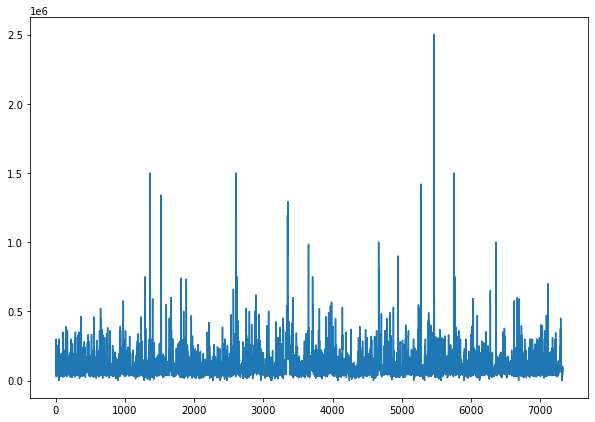

In [13]:
# Ploting prices for apartments that are listed for sale
real_estate[(real_estate['listing_type'] == 's') & (real_estate['property_type'] == 'a')]['price'].plot(figsize=(10,7))

In [14]:
# Looking at the apartments that have price which is too low and implies that it was an error in the ad on the website
# We're listing apartments for sale that have price < 10,000 EUR

indexes_to_remove = real_estate[(real_estate['price'] < 10000) & (real_estate['listing_type'] == 's') & (real_estate['property_type'] == 'a')].index
real_estate.iloc[indexes_to_remove,:].head()

,id,listing_type,property_type,price,location_city,location_city_district,area_property,area_land,construction_type,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms,source
48,186,s,a,720.0,Sombor opština,Sombor grad,89.0,NaN,2020,NaN,NaN,False,Gas,4.0,1.0,https://www.4zida.rs/prodaja/stanovi/sombor-op...
902,1036,s,a,1100.0,Kragujevac,Gradske lokacije,92.0,NaN,2019,NaN,NaN,True,None,3.0,1.0,https://www.4zida.rs/prodaja/stanovi/kragujeva...
1280,1453,s,a,870.0,Novi Sad,Adice,81.0,NaN,2009,3.0,3.0,True,Gas,3.0,1.0,https://www.4zida.rs/prodaja/stanovi/novi-sad/...
1330,1503,s,a,9500.0,Zrenjanin opština,Aradac,78.0,NaN,None,NaN,0.0,True,Etažno,3.0,2.0,https://www.4zida.rs/prodaja/stanovi/zrenjanin...
1362,1535,s,a,3000.0,Boljevac opština,Bogovina,40.0,NaN,None,NaN,NaN,False,None,1.0,1.0,https://www.4zida.rs/prodaja/stanovi/boljevac-...


In [15]:
print(f'There are {len(indexes_to_remove)} apartments entries to be removed.')

There are 29 apartments entries to be removed.


In [16]:
# Removing those apartments with unreasonably low selling price
real_estate = real_estate.drop(indexes_to_remove)

### 3.1.2. Houses and their selling price

We are looking at the price that is unreasonably low in order to be a valid selling price for a house.

<AxesSubplot:>

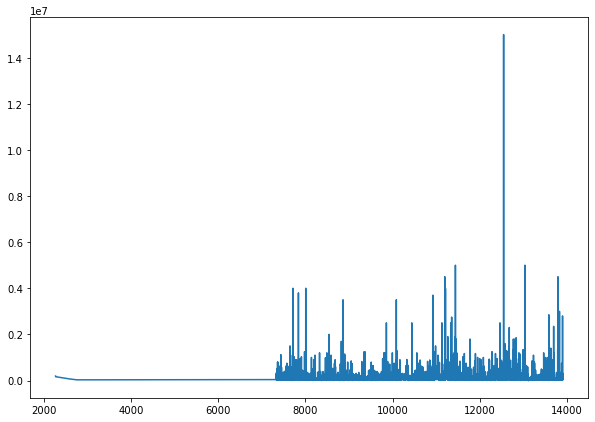

In [17]:
# Ploting prices for houses that are listed for sale
real_estate[(real_estate['listing_type'] == 's') & (real_estate['property_type'] == 'h')]['price'].plot(figsize=(10,7))

In [18]:
# Looking at the houses that have price which is too low and implies that it was an error in the ad on the website
# We're listing houses for sale that have price < 10,000 EUR

indexes_to_remove = real_estate[(real_estate['listing_type'] == 's') & (real_estate['property_type'] == 'h') & (real_estate['price'] < 10000)].index
real_estate[(real_estate['listing_type'] == 's') & (real_estate['property_type'] == 'h') & (real_estate['price'] < 10000)].head()

,id,listing_type,property_type,price,location_city,location_city_district,area_property,area_land,construction_type,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms,source
7633,7990,s,h,6000.0,Beograd,Obrenovac,60.0,14.0,None,NaN,NaN,False,Kaljeva peć,NaN,1.0,https://www.4zida.rs/prodaja/kuce/beograd/ogla...
7674,8031,s,h,1.0,Beograd,Rakovica,87.0,16.0,1986,NaN,NaN,True,Struja,NaN,1.0,https://www.4zida.rs/prodaja/kuce/beograd/ogla...
7713,8071,s,h,1.0,Sremski Karlovci opština,Sremski Karlovci grad,330.0,NaN,None,NaN,NaN,True,Centralno,NaN,1.0,https://www.4zida.rs/prodaja/kuce/sremski-karl...
7727,8085,s,h,8500.0,Zrenjanin opština,Ečka,120.0,4.5,None,NaN,NaN,False,None,NaN,1.0,https://www.4zida.rs/prodaja/kuce/zrenjanin-op...
7786,8144,s,h,9900.0,Alibunar opština,Dobrica,178.0,24.0,None,NaN,NaN,True,None,NaN,1.0,https://www.4zida.rs/prodaja/kuce/alibunar-ops...


In [19]:
print(f'There are {len(indexes_to_remove)} houses entries to be removed.')

There are 96 houses entries to be removed.


In [20]:
# Removing those houses with unreasonably low selling price
real_estate = real_estate.drop(indexes_to_remove)

### 3.1.3. Apartments and their monthly renting price


We are looking at the price that is either an unreasonably low or an unreasonably high  in order to be a valid monthly renting price for an apartment.

<AxesSubplot:>

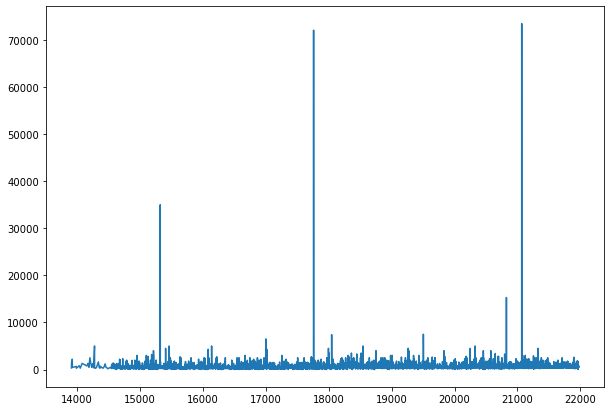

In [21]:
# Ploting prices for apartments that are listed for rent
real_estate[(real_estate['listing_type'] == 'r') & (real_estate['property_type'] == 'a')]['price'].plot(figsize=(10,7))

In [22]:
# Looking at the apartments that have renting price which is too low and implies that it was an error in the ad on the website
# We're listing apartments for rent that have montly renth price < 50 EUR

indexes_to_remove = real_estate[(real_estate['price'] < 50) & (real_estate['listing_type'] == 'r') & (real_estate['property_type'] == 'a')].index
real_estate[(real_estate['price'] < 50) & (real_estate['listing_type'] == 'r') & (real_estate['property_type'] == 'a')].head()

,id,listing_type,property_type,price,location_city,location_city_district,area_property,area_land,construction_type,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms,source
14612,15037,r,a,25.0,Novi Sad,Nova Detelinara,24.0,NaN,None,NaN,0.0,False,Centralno,1.0,1.0,https://www.4zida.rs/izdavanje/stanovi/novi-sa...
14622,15047,r,a,45.0,Vrnjačka Banja opština,Vrnjačka Banja grad,55.0,NaN,2018,3.0,1.0,False,Centralno,1.0,1.0,https://www.4zida.rs/izdavanje/stanovi/vrnjack...
14623,15048,r,a,20.0,Vrnjačka Banja opština,Vrnjačka Banja grad,32.0,NaN,None,NaN,NaN,False,None,1.0,1.0,https://www.4zida.rs/izdavanje/stanovi/vrnjack...
14624,15049,r,a,40.0,Gradske lokacije,Medijana,20.0,NaN,2019,NaN,0.0,False,Struja,1.0,1.0,https://www.4zida.rs/izdavanje/stanovi/nis/ogl...
14625,15050,r,a,35.0,Beograd,Novi Beograd,32.0,NaN,None,7.0,2.0,False,Centralno,1.0,1.0,https://www.4zida.rs/izdavanje/stanovi/beograd...


In [23]:
print(f'There are {len(indexes_to_remove)} apartments entries to be removed.')

There are 173 apartments entries to be removed.


In [24]:
# Removing those apartments with unreasonably low monthly rent price
real_estate = real_estate.drop(indexes_to_remove)

In [25]:
# Looking at the apartments that have renting price which is too high in order to be a valid montly renting price.
# Those apartments imply that it was an error in the ad on the website.
# We're listing apartments for rent that have montly renth price < 50 EUR

indexes_to_remove = real_estate[(real_estate['price'] > 10000) & (real_estate['listing_type'] == 'r') & (real_estate['property_type'] == 'a')].index
real_estate[(real_estate['price'] > 10000) & (real_estate['listing_type'] == 'r') & (real_estate['property_type'] == 'a')].head()

,id,listing_type,property_type,price,location_city,location_city_district,area_property,area_land,construction_type,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms,source
15322,15747,r,a,35000.0,Novi Sad,Veternik,76.0,NaN,None,2.0,2.0,False,Gas,3.0,1.0,https://www.4zida.rs/izdavanje/stanovi/novi-sa...
17760,18185,r,a,72100.0,Srbija,Novi Sad,62.0,NaN,None,5.0,1.0,False,Centralno,2.5,1.0,https://www.4zida.rs/izdavanje/stanovi/novi-sa...
20825,21250,r,a,15300.0,Beograd,Stari Grad,900.0,NaN,None,NaN,0.0,True,Centralno,NaN,1.0,https://www.4zida.rs/izdavanje/stanovi/beograd...
21068,21493,r,a,73500.0,Novi Sad,Liman 3,49.0,NaN,None,8.0,8.0,True,Centralno,2.0,1.0,https://www.4zida.rs/izdavanje/stanovi/novi-sa...


In [26]:
print(f'There are {len(indexes_to_remove)} apartments entries to be removed.')

There are 4 apartments entries to be removed.


In [27]:
# Removing those apartments with unreasonably low monthly rent price
real_estate = real_estate.drop(indexes_to_remove)

### 3.1.4. Houses and their monthly renting price


We are looking at the price that is either an unreasonably low or an unreasonably high  in order to be a valid monthly renting price for a house.

<AxesSubplot:>

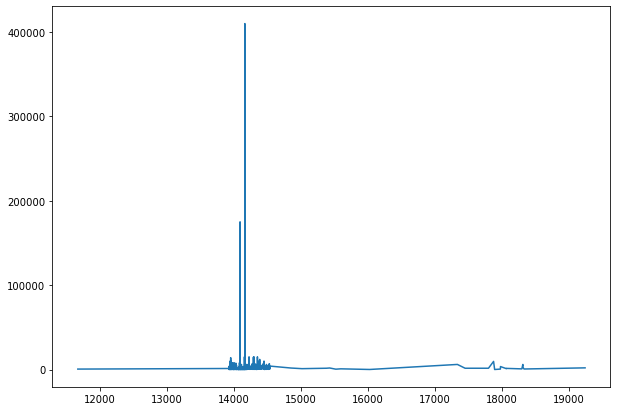

In [28]:
# Ploting prices for apartments that are listed for rent
real_estate[(real_estate['listing_type'] == 'r') & (real_estate['property_type'] == 'h')]['price'].plot(figsize=(10,7))

In [29]:
# Looking at the houses that have renting price which is too low and implies that it was an error in the ad on the website
# We're listing houses for rent that have montly renth price < 30 EUR

indexes_to_remove = real_estate[(real_estate['price'] < 30) & (real_estate['listing_type'] == 'r') & (real_estate['property_type'] == 'h')].index
real_estate.iloc[indexes_to_remove, :].head()

,id,listing_type,property_type,price,location_city,location_city_district,area_property,area_land,construction_type,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms,source
14087,14511,r,h,250.0,Beograd,Palilula,90.0,NaN,None,NaN,NaN,False,Etažno,NaN,1.0,https://www.4zida.rs/izdavanje/kuce/beograd/og...
14091,14515,r,h,180.0,Beograd,Čukarica,30.0,NaN,2000,NaN,NaN,False,TA peć,NaN,1.0,https://www.4zida.rs/izdavanje/kuce/beograd/og...
14106,14530,r,h,40.0,Kopaonik opština,Kopaonik grad,60.0,NaN,None,NaN,NaN,False,None,NaN,1.0,https://www.4zida.rs/izdavanje/kuce/kopaonik-o...
14143,14567,r,h,8.0,Zrenjanin opština,Zrenjanin grad,130.0,NaN,None,NaN,NaN,False,Norveški radijatori,NaN,2.0,https://www.4zida.rs/izdavanje/kuce/zrenjanin-...
14177,14601,r,h,50.0,Beograd,Voždovac,81.0,9.0,None,NaN,NaN,False,Gas,NaN,2.0,https://www.4zida.rs/izdavanje/kuce/beograd/og...


In [30]:
print(f'There are {len(indexes_to_remove)} houses entries to be removed.')

There are 26 houses entries to be removed.


In [31]:
# Removing those houses with unreasonably low monthly rent price
real_estate = real_estate.drop(indexes_to_remove)

In [32]:
# Looking at the houses that have monthly renting price which is too high and implies that it was an error in the ad on the website
# We're listing houses for rent that have montly renth price > 100,000 EUR

indexes_to_remove = real_estate[(real_estate['price'] > 100000) & (real_estate['listing_type'] == 'r') & (real_estate['property_type'] == 'h')].index
real_estate[(real_estate['price'] > 100000) & (real_estate['listing_type'] == 'r') & (real_estate['property_type'] == 'h')]

,id,listing_type,property_type,price,location_city,location_city_district,area_property,area_land,construction_type,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms,source
14094,14518,r,h,175000.0,Novi Sad,Adice,209.0,NaN,None,NaN,NaN,False,None,NaN,1.0,https://www.4zida.rs/izdavanje/kuce/novi-sad/o...
14165,14589,r,h,410000.0,Zlatibor opština,Zlatibor grad,202.0,509.0,1970,NaN,NaN,False,Etažno,NaN,1.0,https://www.4zida.rs/izdavanje/kuce/zlatibor-o...


In [33]:
print(f'There are {len(indexes_to_remove)} houses entries to be removed.')

There are 2 houses entries to be removed.


In [34]:
# Removing those houses with unreasonably high monthly rent price
real_estate = real_estate.drop(indexes_to_remove)

## 3.2. Searching for outliers based on real estate's number of bathrooms

<AxesSubplot:>

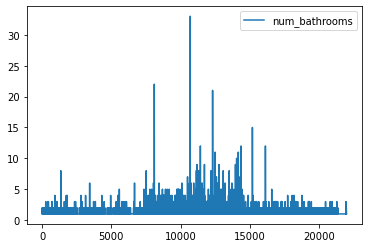

In [35]:
# Displaying number of bathrooms
real_estate[['num_bathrooms']].plot()

In [36]:
# Looking for the real estate listings that have 10 or more bathrooms in the description f the listing. 
# Assumption that is being thake is that in order to have 10+ bathroom in the real estate:
# 1. Property area shoud be 300 square meters or more
# 2. Price should be 200,000+ EUR

indexes_to_remove = real_estate[(real_estate['num_bathrooms'] > 10) & (real_estate['area_property'] < 300) & (real_estate['price'] < 200000)].index
real_estate[(real_estate['num_bathrooms'] > 10) & (real_estate['area_property'] < 300) & (real_estate['price'])]

,id,listing_type,property_type,price,location_city,location_city_district,area_property,area_land,construction_type,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms,source
8095,8453,s,h,60000.0,Pećinci opština,Šimanovci,260.0,18.0,1995,NaN,NaN,True,Struja,NaN,22.0,https://www.4zida.rs/prodaja/kuce/pecinci-opst...
10693,11051,s,h,105000.0,Beograd,Grocka,277.0,4.0,1991,NaN,NaN,True,Struja,NaN,33.0,https://www.4zida.rs/prodaja/kuce/beograd/ogla...
11421,11778,s,h,68000.0,Zrenjanin opština,Zrenjanin grad,210.0,6.0,None,NaN,NaN,False,None,NaN,12.0,https://www.4zida.rs/prodaja/kuce/zrenjanin-op...
12475,12832,s,h,50000.0,Kraljevo opština,Kraljevo grad,89.0,2.0,None,NaN,NaN,True,Etažno,NaN,11.0,https://www.4zida.rs/prodaja/kuce/kraljevo-ops...
15178,15602,r,a,1200.0,Beograd,Vračar,200.0,NaN,None,6.0,5.0,False,Centralno,5.0,15.0,https://www.4zida.rs/izdavanje/stanovi/beograd...
16117,16542,r,a,300.0,Novi Beograd,Bežanijska Kosa,35.0,NaN,None,5.0,3.0,False,Centralno,1.5,12.0,https://www.4zida.rs/izdavanje/stanovi/beograd...


In [37]:
print(f'There are {len(indexes_to_remove)} real estate properties to be removed.')

There are 6 real estate properties to be removed.


In [38]:
# Removing real estate listings with lagre number of bathrooms (outliers)
real_estate = real_estate.drop(indexes_to_remove)

## 3.3. Searching for outliers based on real estate's area 

<AxesSubplot:>

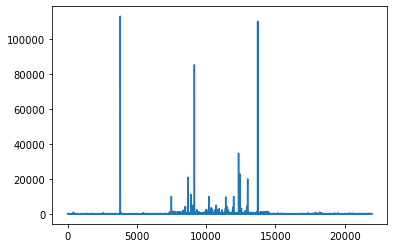

In [39]:
real_estate['area_property'].plot()

In [40]:
# Searching for real estate listings that have enormous property area
# (more then 10,000 square meters which would obviously be too much for any house or apartment, based on prices)

indexes_to_remove = real_estate[real_estate['area_property']>10000].index
real_estate[real_estate['area_property']>10000]

,id,listing_type,property_type,price,location_city,location_city_district,area_property,area_land,construction_type,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms,source
3798,3973,s,a,364000.0,Beograd,Palilula,113000.0,NaN,None,4.0,2.0,True,Centralno,4.0,2.0,https://www.4zida.rs/prodaja/stanovi/beograd/o...
8674,9032,s,h,185000.0,Inđija opština,Banstol - Vikend Naselje,21000.0,NaN,None,NaN,NaN,True,None,NaN,1.0,https://www.4zida.rs/prodaja/kuce/indjija-opst...
8917,9275,s,h,99900.0,Bačka Palanka opština,Bačka Palanka grad,11206.0,NaN,1998,NaN,NaN,True,None,NaN,1.0,https://www.4zida.rs/prodaja/kuce/backa-palank...
9147,9505,s,h,69000.0,Sombor opština,Obzir,85200.0,NaN,None,NaN,NaN,False,None,NaN,1.0,https://www.4zida.rs/prodaja/kuce/sombor-opsti...
12338,12694,s,h,123600.0,Žabalj opština,Žabalj grad,34750.0,NaN,None,NaN,NaN,True,None,NaN,1.0,https://www.4zida.rs/prodaja/kuce/zabalj-opsti...
12437,12793,s,h,257500.0,Novi Sad,Čenej,22842.0,NaN,None,NaN,NaN,True,Etažno,NaN,1.0,https://www.4zida.rs/prodaja/kuce/novi-sad/ogl...
12996,13353,s,h,113500.0,Beočin opština,Beočin grad,20000.0,NaN,None,NaN,NaN,False,Centralno,NaN,1.0,https://www.4zida.rs/prodaja/kuce/beocin-opsti...
13714,14072,s,h,49000.0,Beograd,Grocka,110000.0,NaN,None,NaN,NaN,False,None,NaN,1.0,https://www.4zida.rs/prodaja/kuce/beograd/ogla...
13761,14119,s,h,42000.0,Beograd,Sopot,110000.0,15.0,None,NaN,NaN,False,None,NaN,1.0,https://www.4zida.rs/prodaja/kuce/beograd/ogla...


In [41]:
print(f'There are {len(indexes_to_remove)} real estate properties to be removed.')

There are 9 real estate properties to be removed.


In [42]:
# Removing real estate listings with lagre number of bathrooms (outliers)
real_estate = real_estate.drop(indexes_to_remove)

In [43]:
# Searching for real estate listings that have area property which is too little in order to be a valid entry
# (less then 10 square meters which would obviously be too much for any house or apartment, based on prices)

indexes_to_remove = real_estate[real_estate['area_property']<10].index
real_estate[real_estate['area_property']<10]

,id,listing_type,property_type,price,location_city,location_city_district,area_property,area_land,construction_type,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms,source
7677,8034,s,h,119000.0,Gradske lokacije,Palilula,1.0,NaN,None,NaN,NaN,False,None,NaN,2.0,https://www.4zida.rs/prodaja/kuce/nis/oglas/de...
8880,9238,s,h,70000.0,Žabalj opština,Žabalj grad,1.0,NaN,2000,NaN,NaN,False,None,NaN,1.0,https://www.4zida.rs/prodaja/kuce/zabalj-opsti...
9704,10062,s,h,160000.0,Niš,Gradske lokacije,1.0,NaN,None,NaN,NaN,True,None,NaN,1.0,https://www.4zida.rs/prodaja/kuce/nis/oglas/bu...
10725,11083,s,h,50000.0,Sokobanja opština,Sokobanja grad,1.0,1.0,1972,NaN,NaN,True,Struja,NaN,1.0,https://www.4zida.rs/prodaja/kuce/sokobanja-op...
12360,12716,s,h,133900.0,Novi Sad,None,1.0,NaN,None,NaN,NaN,True,None,NaN,1.0,https://www.4zida.rs/prodaja/kuce/novi-sad/ogl...
12807,13164,s,h,20000.0,Jagodina opština,Jagodina grad,1.0,NaN,None,NaN,NaN,True,Centralno,NaN,1.0,https://www.4zida.rs/prodaja/kuce/jagodina-ops...
14368,14793,r,a,300.0,Beograd,Novi Beograd,5.0,NaN,None,NaN,NaN,False,Centralno,2.5,1.0,https://www.4zida.rs/izdavanje/stanovi/beograd...
14782,15207,r,a,400.0,Beograd,Zvezdara,4.0,NaN,None,NaN,3.0,True,Centralno,1.5,1.0,https://www.4zida.rs/izdavanje/stanovi/beograd...
17659,18084,r,a,100.0,Beograd,Palilula,7.0,NaN,None,4.0,1.0,False,Etažno,8.0,2.0,https://www.4zida.rs/izdavanje/stanovi/beograd...
17891,18316,r,a,230.0,Novi Beograd,Bežanijska Kosa,2.0,NaN,None,NaN,NaN,False,Centralno,1.0,1.0,https://www.4zida.rs/izdavanje/stanovi/beograd...


In [44]:
print(f'There are {len(indexes_to_remove)} real estate properties to be removed.')

There are 12 real estate properties to be removed.


In [45]:
# Removing real estate listings with lagre number of bathrooms (outliers)
real_estate = real_estate.drop(indexes_to_remove)

## 3.4. Searching for outliers based on real estate's number of rooms

<AxesSubplot:>

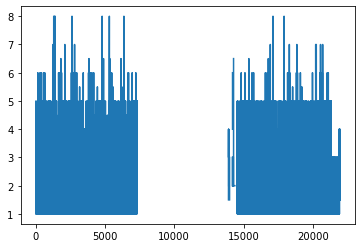

In [46]:
real_estate['num_rooms'].plot()

In [47]:
# There are no real estate listings that have more than 10 rooms in the property
real_estate[real_estate['num_rooms']>10]

,id,listing_type,property_type,price,location_city,location_city_district,area_property,area_land,construction_type,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms,source


# 4. City and city district are being storred inversely

We will rotate and replace values in columns "location_city" and "location_district". We know that those values are being replaced because under "location_city" column, we find word "opština", which designates certain district withing the city. Similary, in column "location_district", we can find word "grad", which means that name for district is actually name for a city.

After we replace the values in those columns, we will also remove words "opština" and "grad" from the location values.

In [48]:
indexes_to_replace = real_estate[real_estate['location_city'].str.contains('opština') & real_estate['location_city_district'].str.contains('grad')].index
real_estate[real_estate['location_city'].str.contains('opština') & real_estate['location_city_district'].str.contains('grad')].head()

,id,listing_type,property_type,price,location_city,location_city_district,area_property,area_land,construction_type,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms,source
10,102,s,a,28000.0,Subotica opština,Subotica grad,35.0,NaN,None,NaN,0.0,False,None,1.0,1.0,https://www.4zida.rs/prodaja/stanovi/subotica-...
12,104,s,a,46000.0,Zlatibor opština,Zlatibor grad,32.0,NaN,2020,2.0,0.0,False,None,1.5,1.0,https://www.4zida.rs/prodaja/stanovi/zlatibor-...
21,1398,s,a,40000.0,Zaječar opština,Zaječar grad,68.0,NaN,1965,3.0,2.0,True,Etažno,3.0,1.0,https://www.4zida.rs/prodaja/stanovi/zajecar-o...
22,1399,s,a,75000.0,Kruševac opština,Kruševac grad,90.0,NaN,2018,4.0,4.0,False,Gas,4.0,2.0,https://www.4zida.rs/prodaja/stanovi/krusevac-...
55,192,s,a,150000.0,Subotica opština,Subotica grad,196.0,NaN,None,NaN,NaN,True,Etažno,4.0,2.0,https://www.4zida.rs/prodaja/stanovi/subotica-...


In [49]:
def replace_values_for_city_and_district_columns(index):
    """Replaces values between two columns 'location_city' and 'location_district'."""
    try:
        city_placeholder = real_estate.iloc[index, :]['location_city']
        district_placeholder = real_estate.iloc[index,:]['location_city_district']
        district_placeholder = district_placeholder.replace('grad', '').strip()

        real_estate.at[index, 'location_city'] = district_placeholder
        real_estate.at[index, 'location_city_district'] = city_placeholder
    except Exception as e:
        pass

In [50]:
# Swaping two columns

print(f'Swaping two columns for {len(indexes_to_replace)}')
for index in indexes_to_replace:
    replace_values_for_city_and_district_columns(index)

Swaping two columns for 2175


# 5. Saving the results

In [51]:
len(real_estate)

21604

## 5.1. Exporting to csv file

In [52]:
# Saving results to the csv file
real_estate.to_csv('../database/backup/properties_cleaned_data.csv',index=False)

## 5.2. Inserting into database

Creating new table for cleaned data and inserting results there.

### 5.2.1. Creating new table "properties_clean"

In [53]:
# # Connecting to the database
# conn = psycopg2.connect(
#     host=db_params['host'], 
#     port=db_params['port'], 
#     database=db_params['database'], 
#     user=db_params['user'], 
#     password=db_params['password']
#     )

In [54]:
# create_table_query = """
# CREATE TABLE IF NOT EXISTS properties_clean
# (
#     id int  PRIMARY KEY,   
#     listing_type "char",
#     property_type "char",
#     price real,
#     location_city text,
#     location_city_district text,
#     area_property real,
#     area_land real,
#     construction_type text,
#     num_floors_building integer,
#     apartment_floor real,
#     registered boolean,
#     heating_type text,
#     num_rooms real,
#     num_bathrooms integer,
#     source text         
# );
# """

In [55]:
# # Creating new table
# cur = conn.cursor()
# cur.execute(create_table_query)
# cur.close()
# conn.commit()

### 5.2.2. Inserting cleaned data into newly created table - "properties_clean"

In [56]:
# Creating new PostgreSQL engine 
from sqlalchemy import create_engine

postgres_engine_parameters = "postgresql://{}:{}@{}:{}/{}".format(
    db_params['user'],
    db_params['password'],
    db_params['host'],
    db_params['port'],
    db_params['database'],
)

postgres_engine = create_engine(postgres_engine_parameters)

In [57]:
# Inserting cleaned data into "properties_clean" table via sqlalchemy engine 
real_estate.to_sql('properties_clean', postgres_engine, index=False)

# 6. Closing database connection

In [58]:
# Closing connection
if conn:
    conn.close()